# VRP RL

In [0]:
import numpy as np
import torch
import random
import math
import time
import os

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
class Config:
    def __init__(self):
        self.truckCapacity = 100
        self.numCust = 10
        self.numDepot = 1
        self.randomSeed = 1       
        self.numEpisode = 15000
        self.embeddingDimension = 5
        self.embeddingIteration = 1
        self.nnNodeDimension = 5
        self.numPaddingLayers = 1
        self.numPrevStates = 10000
        self.numQLStep = 2
        self.gdBatchSize = 16
        self.epsilonMin = 0.1
        self.epsilonDR = 0.0006
        self.checkpointFolder = "./checkPointsUpdated"
        self.depotReward = 10
        self.minEventsForGD = 3000
        self.checkPointThreshold = 200

In [0]:
config = Config()
np.random.seed(config.randomSeed)
random.seed(config.randomSeed)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cpu')
torch.manual_seed(config.randomSeed)  

In [0]:
class State:
    def __init__(self, createNew = True, numCust=None, numDepots = None, capacity = None, visitedNodes = None, nodeLocations = None, demands = None, nodeDistances = None):
        
        if createNew:
            self.visitedNodes = []
            self.satisfiedDemand = 0
            self.nodeLocations, self.nodeDistances, self.demands = generateNodes(numCust, numDepots)
            self.leftDemand = sum(self.demands)
            self.truckCapacity = capacity
        else:
            self.visitedNodes = visitedNodes
            self.satisfiedDemand = sum([demands[node] for node in visitedNodes])
            self.nodeLocations, self.nodeDistances, self.demands = nodeLocations, nodeDistances, demands
            self.truckCapacity = capacity
            self.leftDemand = 0
            for node in range(len(demands)):
                if node not in visitedNodes:
                    self.leftDemand += self.demands[node]
        
        
    def getTensor(self):
        numNodes = self.nodeLocations.shape[0]
        tensor = []
        for i in range(0, numNodes):
            tmp = []
            tmp.append(0 if self.demands[i] > 0 else 0)
            tmp.append(-1 if i not in self.visitedNodes else self.visitedNodes.index(i))
            tmp.append(self.nodeLocations[i, 0])
            tmp.append(self.nodeLocations[i, 1])
            tmp.append(self.leftDemand)
            tensor.append(tmp) 
        return torch.tensor(tensor, dtype=torch.float32, requires_grad=False, device=device)
    
    def isFinalState(self):
        return self.leftDemand == 0

In [0]:
class Utils:
    def __init__(self):
        pass
    def generateNodes(self):
        global config
        nodeLocations = np.random.uniform(size=(config.numCust + config.numDepot ,2))
        nodeDistances = distance_matrix(nodeLocations, nodeLocations)
        demands = np.random.randint(1, 10, (config.numCust + config.numDepot))
        for i in range(config.numDepot):
            demands[i] = 0
        return nodeLocations, nodeDistances, demands
    
    def distanceTravelled(self, nodeDistances, visitedNodes):
        distTravelled = 0
        if len(visitedNodes) > 2:
            for i in range(len(visitedNodes) - 1):
                distTravelled += nodeDistances[visitedNodes[i], visitedNodes[i+1]].item()
        return distTravelled
    
    def nextRandomNode(self, state):
        global config
        if len(state.visitedNodes) == 0:
            return np.random.randint(0, (config.numCust + config.numDepot))
        elif state.satisfiedDemand == state.truckCapacity:
            return np.random.randint(0, config.numDepot)

        visited = set(state.visitedNodes)
        nodes = np.random.randint(0, (config.numCust + config.numDepot), (config.numCust + config.numDepot))
        for node in nodes:
            if node not in visited:
                return node
        return random.choice(nodes).item()
    
    def calculateReward(self, visitedNodes, newVisitedNodes, nodeDistances):
        global config
        newTotalDistance = self.distanceTravelled(nodeDistances, newVisitedNodes)
        oldTotalDistance = self.distanceTravelled(nodeDistances, visitedNodes)
        
        reward = -1.0 * (newTotalDistance - oldTotalDistance)
        if newVisitedNodes[-1] < config.numDepot:
            reward -= config.depotReward
        
        return reward
    
    def plotGraph(self, nodeLocations, visitedNodes):
        plt.scatter(nodeLocations[:,0], nodeLocations[:,1])
        n = len(nodeLocations)
        for idx in range(len(visitedNodes)-1):
          plt.plot([nodeLocations[visitedNodes[idx], 0], nodeLocations[visitedNodes[idx+1], 0]], [nodeLocations[visitedNodes[idx], 1], nodeLocations[visitedNodes[idx+1], 1]], 'k', lw=2, alpha=0.8)
        # plt.plot([nodeLocations[visitedNodes[-1], 0], nodeLocations[visitedNodes[0], 0]], [nodeLocations[visitedNodes[-1], 1], nodeLocations[visitedNodes[0], 1]], 'k', lw=2, alpha=0.8)
        for node in visitedNodes:
          if node < config.numDepot:
            plt.plot(nodeLocations[node, 0], nodeLocations[node, 1], 'X', markersize=15)
    
    def getEpsilonValueForEpisode(self, episode):
        global config
        episodeValue = (1-config.epsilonDR)**episode
        return max(config.epsilonMin, episodeValue)
    
    def getSamplesForEpisode(self):
        nodeLocations, nodeDistances, demands = self.generateNodes()
        global config
        nodeDistances = torch.tensor(nodeDistances, dtype=torch.float32, requires_grad=False, device=device)
        visitedNodes = [random.randint(0, config.numDepot-1)]
        return nodeLocations, nodeDistances, demands, visitedNodes

In [0]:
utils = Utils()

In [0]:
class Event():
    def __init__(self, state, nextState, reward, action):
        self.state = state
        self.stateTensor = state.getTensor()
        self.nextState = nextState
        self.nextStateTensor = nextState.getTensor()
        self.reward = reward
        self.action = action
        
class History():
    def __init__(self):
        global config
        self.pastEvents = []
        self.numEvents = 0
        
    def addPastEvent(self, event):
        global config
        if self.numEvents > config.numPrevStates:
            self.pastEvents[self.numEvents % config.numPrevStates] = event
        else:
            self.pastEvents.append(event)
        self.numEvents += 1
        
    def getNumPastEvents(self):
        if self.numEvents > len(self.pastEvents):
            return len(self.pastEvents)
        else:
            return self.numEvents
        
    def getSamplePast(self):
        global config
        return random.sample(self.pastEvents, config.gdBatchSize)
    
    def addToHistory(self, visitedNodes, rewards, states, newState, actions):
        global config
        if len(visitedNodes) >= config.numQLStep:
            lastState = states[-config.numQLStep]
            rewardsSum = sum(rewards[-config.numQLStep:])
            actionPerformed = actions[-config.numQLStep]
            newEvent = Event(lastState, newState, rewardsSum, actionPerformed)
            self.addPastEvent(newEvent)
            
        if newState.isFinalState():
            for step in range(1, config.numQLStep):
                lastState = states[-step]
                rewardsSum = sum(rewards[-step:])
                actionPerformed = actions[-step]
                event = Event(lastState, newState, rewardsSum, actionPerformed)
                self.addPastEvent(event)

In [0]:
class DQN(nn.Module):    
    def __init__(self):
        super(DQN, self).__init__()
        
        global config
         
        self.theta1 = nn.Linear(config.nnNodeDimension, config.embeddingDimension, True)
        self.theta2 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        self.theta3 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        self.theta4 = nn.Linear(1, config.embeddingDimension, True)
        self.theta5 = nn.Linear(2*config.embeddingDimension, 1, True)
        self.theta6 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        self.theta7 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        
        self.padding = []
        for i in range(config.numPaddingLayers):
            self.padding.append(nn.Linear(config.embeddingDimension, config.embeddingDimension, True))
        
    def forward(self, features, nodeLocations):
        global config
    
        term1 = self.theta1(features)
        for layer in self.padding:
            term1 = layer(F.relu(term1))
        term3 = self.theta3(torch.sum(F.relu(self.theta4(nodeLocations.unsqueeze(3))), dim=1))
        
        connections = torch.where(nodeLocations > 0, torch.ones_like(nodeLocations), torch.zeros_like(nodeLocations)).to(device)
        mu = torch.zeros(features.shape[0], (config.numCust + config.numDepot), config.embeddingDimension, device=device)
        
        for t in range(config.embeddingIteration):
            term2 = self.theta2(connections.matmul(mu))    
            mu = F.relu(term1 + term2 + term3)
            
        term6 = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, (config.numCust + config.numDepot), 1))
        term7 = self.theta7(mu)
        concat = F.relu(torch.cat([term6, term7], dim=2))
        return self.theta5(concat).squeeze(dim=2)

In [0]:
class Helper():
    def __init__(self):
        global config
        self.network = DQN().to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.005)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.99998)
        self.lossFunc = nn.MSELoss()        
        
    def loadModel(self, fileName):
        global config
        if fileName is not None:
            checkpoint = torch.load(fileName)
            self.network.load_state_dict(checkpoint['network'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['scheduler'])
            
    def saveCheckPoint(self, episode, loss, averageLength):
        global config
        
        # fname = os.path.join(config.checkpointFolder, 'length_{}.tar'.format(averageLength))
        fname = F"gdrive/My Drive/CSC591-ADBI/Capstone/Code/checkPointsUpdated/length_{averageLength}.tar"
        torch.save({'episode': episode, 'network': self.network.state_dict(), 'optimizer': self.optimizer.state_dict(), 'scheduler': self.scheduler.state_dict(), 'loss': loss, 'averageLength': averageLength
        }, fname)
    
    def predict(self, state):
        with torch.no_grad():
            rewards = self.network(state.getTensor().unsqueeze(0), state.nodeDistances.unsqueeze(0))
        return rewards[0]
                
    def getNextAction(self, state):  
        W = state.nodeDistances
        rewards = self.predict(state)
        if state.satisfiedDemand >= state.truckCapacity:
            return 0, rewards[0].item()
        
        rewards = rewards.argsort(descending=True)
        for node in rewards.tolist():
            if (len(state.visitedNodes) == 0 or state.nodeDistances[state.visitedNodes[-1], node] > 0) and node not in state.visitedNodes:
                return node, rewards[node].item()
        
    def update(self, events):
        global confi
        stateTensors = []
        distanceTensors = []
        actions = []
        targets = []
        for event in events:
            stateTensors.append(event.stateTensor)
            distanceTensors.append(event.state.nodeDistances)
            actions.append(event.action)
            
        distanceTensors = torch.stack(distanceTensors).to(device)
        stateTensors = torch.stack(stateTensors).to(device)

        for i, event in enumerate(events):
            target = event.reward
            if not event.nextState.isFinalState():
                node, reward = self.getNextAction(event.nextState)
                target += 0.9 * reward
            targets.append(target)
                
        self.optimizer.zero_grad()
        rewards = self.network(stateTensors, distanceTensors)[range(len(actions)), actions]
        
        loss = self.lossFunc(rewards, torch.tensor(targets, device=device))
        loss = loss.item()
        self.optimizer.step()        
        self.scheduler.step()
        
        return loss

In [12]:
helper = Helper()
history = History()
pathLengths = []
medianPathLength = float('inf')
losses = []

for episode in range(config.numEpisode):
    
    currentEpsilon = utils.getEpsilonValueForEpisode(episode)
    nodeLocations, nodeDistances, demands, visitedNodes = utils.getSamplesForEpisode()
    oldState = State(createNew=False, visitedNodes=visitedNodes, nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = config.truckCapacity)
    oldStateTensor = oldState.getTensor()
    states = [oldState]
    stateTensors = [oldStateTensor]
    rewards = []
    actions = []

    leftCapacity = config.truckCapacity
    while not oldState.isFinalState():
        
        if currentEpsilon < random.random():
            newNode, reward = helper.getNextAction(oldState)
        else:
            newNode = utils.nextRandomNode(oldState)
        
        if(newNode < config.numDepot):
          leftCapacity = config.truckCapacity
        else:
          leftCapacity -= demands[newNode]

        newVisitedNodes = list(visitedNodes)
        newVisitedNodes.append(newNode)   
        reward = utils.calculateReward(visitedNodes, newVisitedNodes, nodeDistances)
        
        newState = State(createNew=False, visitedNodes=newVisitedNodes,nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = leftCapacity)
        newStateTensor = newState.getTensor()

        states.append(newState)
        stateTensors.append(newStateTensor)
        rewards.append(reward)
        actions.append(newNode)
        
        history.addToHistory(visitedNodes, rewards, states, newState, actions)
        
        oldState = newState
        oldStateTensor = newStateTensor
        visitedNodes = newVisitedNodes
        
        loss = None
        if history.getNumPastEvents() > config.minEventsForGD:
            events = history.getSamplePast()
            loss = helper.update(events)
            losses.append(loss)

        if loss and (episode%config.checkPointThreshold == 0):
            medianPathLength = np.median(pathLengths[-100:])
            helper.saveCheckPoint(episode, loss, medianPathLength)
                
    length = utils.distanceTravelled(nodeDistances, visitedNodes)
    pathLengths.append(length)

    if episode % 100 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f' % (episode, (-1 if loss is None else loss), np.median(pathLengths[-50:])))

Ep 0. Loss = -1.000 / median length = 5.713
Ep 100. Loss = -1.000 / median length = 5.570
Ep 200. Loss = -1.000 / median length = 5.535
Ep 300. Loss = 16.941 / median length = 5.596
Ep 400. Loss = 10.040 / median length = 5.393
Ep 500. Loss = 10.019 / median length = 5.134
Ep 600. Loss = 11.170 / median length = 5.370
Ep 700. Loss = 10.432 / median length = 5.290
Ep 800. Loss = 5.584 / median length = 5.316
Ep 900. Loss = 11.674 / median length = 5.543
Ep 1000. Loss = 14.249 / median length = 5.613
Ep 1100. Loss = 9.529 / median length = 5.200
Ep 1200. Loss = 15.131 / median length = 5.233
Ep 1300. Loss = 10.876 / median length = 4.991
Ep 1400. Loss = 11.797 / median length = 5.375
Ep 1500. Loss = 10.585 / median length = 4.968
Ep 1600. Loss = 10.884 / median length = 5.239
Ep 1700. Loss = 15.878 / median length = 5.216
Ep 1800. Loss = 18.983 / median length = 5.055
Ep 1900. Loss = 12.485 / median length = 5.218
Ep 2000. Loss = 18.126 / median length = 5.208
Ep 2100. Loss = 16.887 / me

## Inspect Training Metrics
Let's look at the (moving averages of) loss and path length over training.

Text(0.5, 0, 'episode')

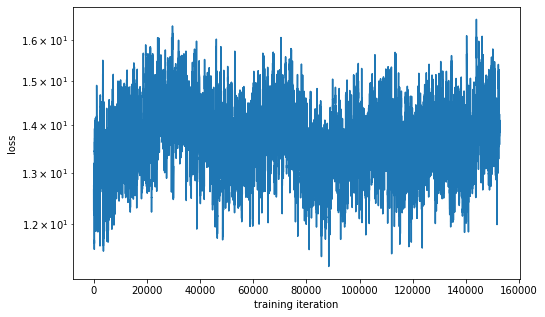

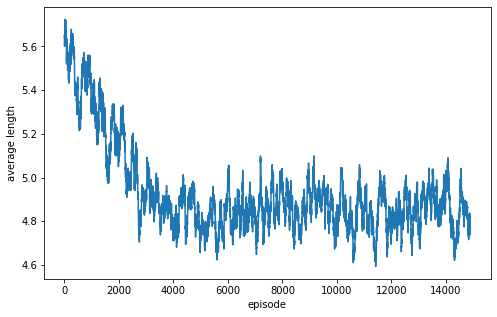

In [13]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(losses), np.ones((100,))/100, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(np.convolve(np.array(losses), np.ones((100,))/100, mode='valid'))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(np.convolve(np.array(pathLengths), np.ones((100,))/100, mode='valid'))
plt.ylabel('average length')
plt.xlabel('episode')

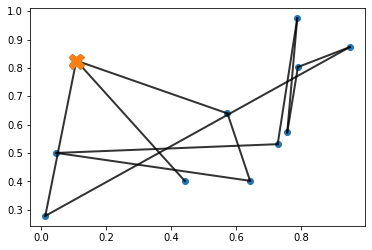

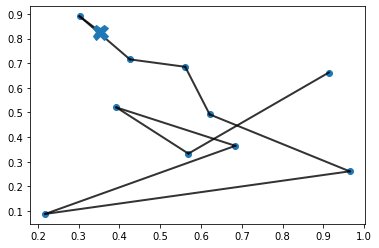

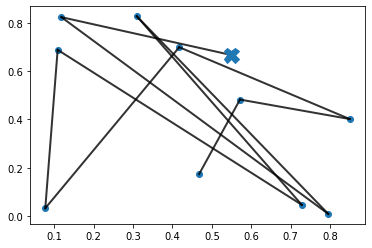

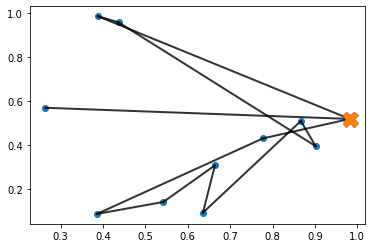

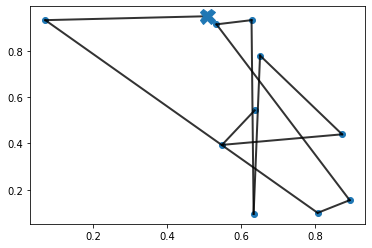

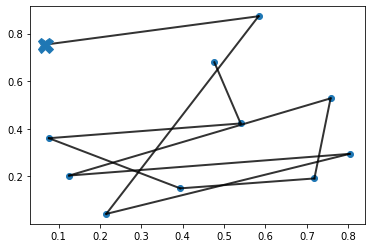

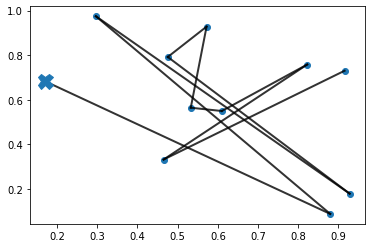

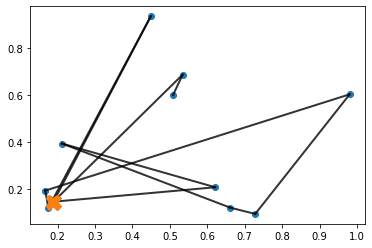

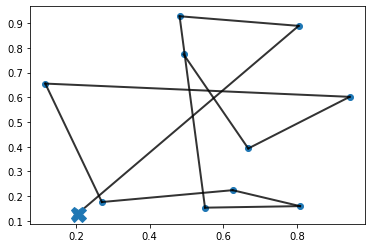

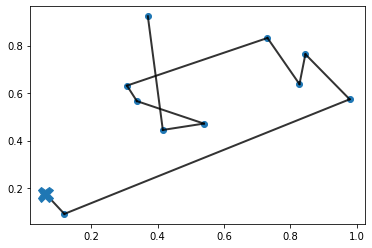

In [36]:
bestModelFileName = F"gdrive/My Drive/CSC591-ADBI/Capstone/Code/checkPointsUpdated/length_4.74465961009264.tar"

testHelper = Helper()
testHelper.loadModel(bestModelFileName)
  
sampleResults = list()

for sample in range(10):
  # print('*****************************' + str(sample))
  nodeLocations, nodeDistances, demands, visitedNodes = utils.getSamplesForEpisode()
  
  oldState = State(createNew=False, visitedNodes=visitedNodes, nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = config.truckCapacity)
  oldStateTensor = oldState.getTensor()
  leftCapacity = config.truckCapacity
  
  while not oldState.isFinalState():        
    newNode, reward = testHelper.getNextAction(oldState)
    visitedNodes.append(newNode)
    if(newNode < config.numDepot):
      leftCapacity = config.truckCapacity
    else:
      leftCapacity -= demands[newNode]
    oldState = State(createNew=False, visitedNodes=visitedNodes,nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = leftCapacity)
    oldStateTensor = oldState.getTensor()
  # print(type(visitedNodes))
  sampleResults.append((nodeLocations, visitedNodes))
    
    
for solution in sampleResults:
    plt.figure()
    utils.plotGraph(solution[0], solution[1])
    